In [1]:
!pip install openai --quiet
!pip install langchain --quiet
!pip install chromadb --quiet
!pip install langchain-community --quiet
!pip install langchain-openai --quiet
!pip install wikipedia --quiet
!pip install duckduckgo-search --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.7/615.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.7/149.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.6 MB/s eta 0:00:

---
## **Configuracion y API Keys**

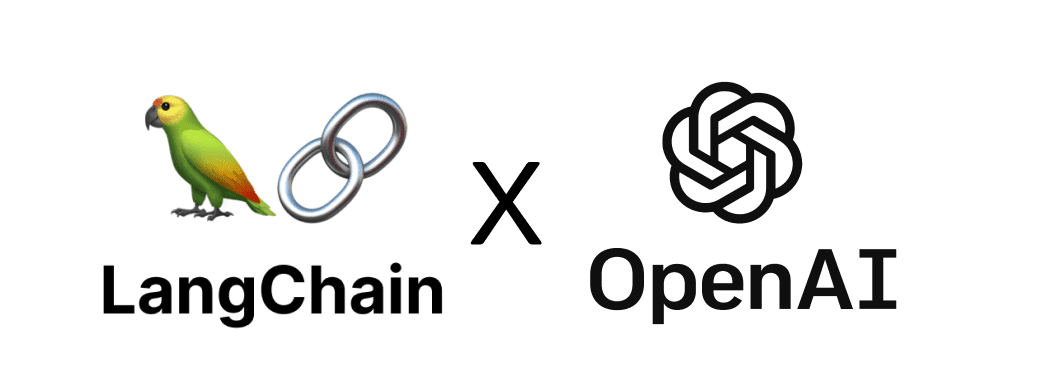

In [2]:
import os
from google.colab import userdata
import numpy as np
from IPython.display import display_markdown

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.agents import Tool
from langchain.document_loaders import TextLoader
from langchain.tools.retriever import create_retriever_tool
from langchain.agents import AgentExecutor, create_react_agent, create_tool_calling_agent
from langchain import hub
from langchain.agents import create_openai_tools_agent
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage
from langchain.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import OpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.retrievers import WikipediaRetriever

In [4]:
# Configure Tavily (for a search engine tool)
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [5]:
# Configuring OpenAI LLM
llm = ChatOpenAI(api_key=userdata.get('OPENAI_API_KEY'), model="gpt-4o-mini")

In [6]:
# Test LLM
response = llm.invoke("Tell me a joke about data scientists")
print(response.content)

Why did the data scientist break up with the statistician?

Because she found him too mean!


---
# **Agente ReAct basico (1 tool)**

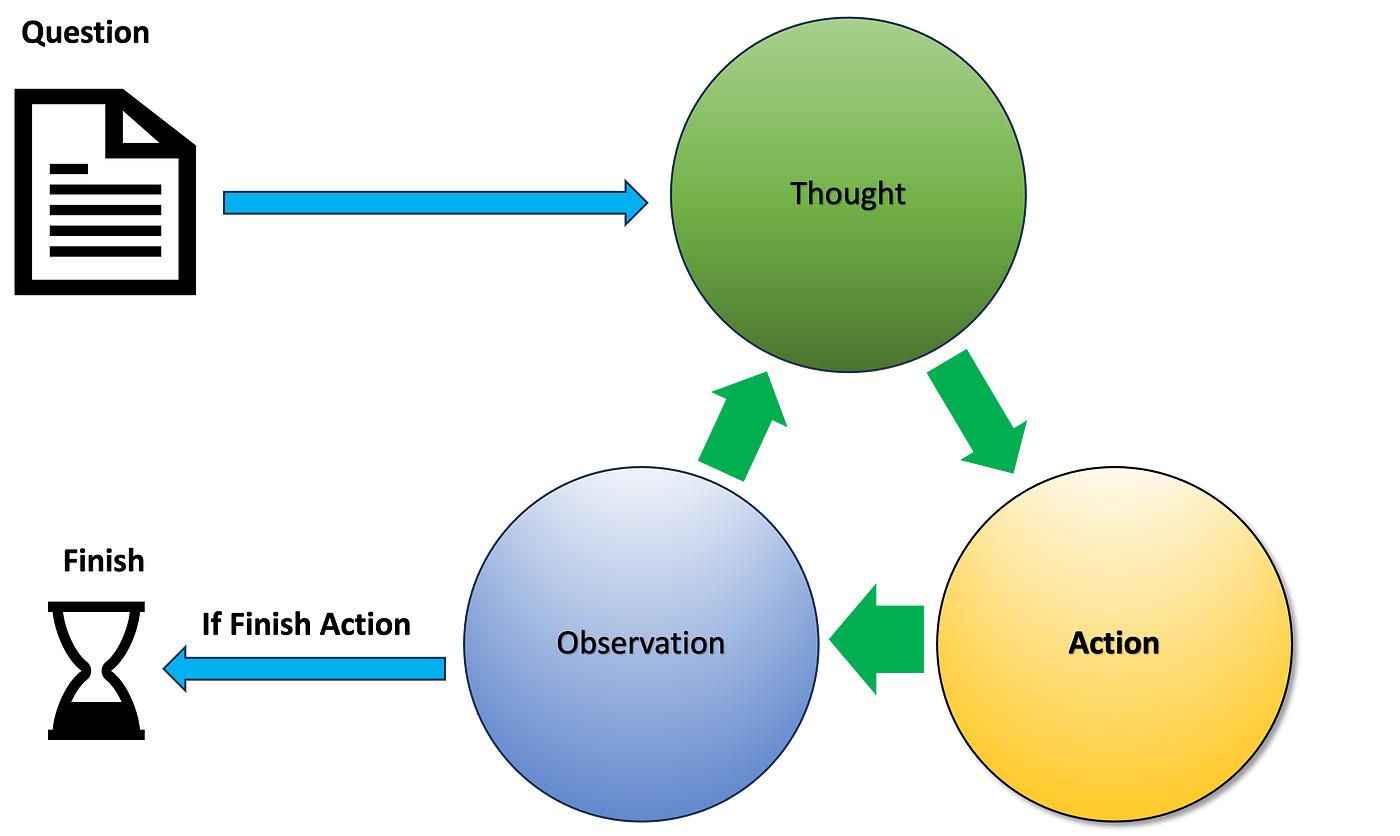

In [7]:
def get_react_agent(llm, tools, prompt, max_iterations=5):
    # Construct the ReAct agent
    agent = create_react_agent(llm, tools, prompt)
    # Create an agent executor by passing in the agent and tools
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,
                                   max_iterations=max_iterations,
                                   handle_parsing_errors=True)

    return agent_executor

In [8]:
# Get the prompt to use - you can modify this!
prompt_react = hub.pull("hwchase17/react")
print(prompt_react.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Se va a configurar solo 1 tool de búsqueda para el agente. [Tavily](https://python.langchain.com/docs/integrations/tools/tavily_search/) es un motor de busqueda para Internet que esta pensado para ser incorporado a agentes basados en LLMs. Tavily necesita la configuración de una APIKEY, pero alternativamente pueden usarse otras herramientas como **Wikipedia** o [DuckDuckGo](https://duckduckgo.com/).

In [9]:
# Try any other question
question1 = "what happens in Geers AI in Tandil?"
# question1 = "How much does Japan spend in defense?"

search = TavilySearchResults(max_results=1)
# search = DuckDuckGoSearchRun()
# search = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

search.run(question1)

[{'url': 'https://geers.in/ai',
  'content': 'GEERS: AI 2 de Octubre & 1 y 2 de Noviembre La evolución exponencial y cómo la inteligencia artificial impacta en el desarrollo de la sociedad. La evolución exponencial y cómo la inteligencia artificial impacta en el desarrollo de la sociedad. Las ediciones de GEERS son impulsadas por la Cluster Tecnológico Tandil, la Universidad Nacional del Centro de la Provincia de Buenos Aires a través de su Facultad de Ciencias Exactas y Subsecretaría de Innovación y Participación Ciudadana dependiente del Municipio de Tandil. GEERS: AI Edition, en el año donde la AI mostró su rostro más desafiante hacia la industria IT, continuar el espacio donde los profesionales de la industria puedan actualizarse y estar al nivel que los desafíos tecnológicos requieren para poder llevar su conocimiento y especialización a cada una de sus empresas.'}]

In [10]:
# Get the agent and run it
tools = [search]

agent = get_react_agent(llm, tools, prompt_react)
agent.invoke({"input": question1})



> Entering new AgentExecutor chain...
I need to find out what is happening with Geers AI in Tandil, which likely involves recent developments or news related to the company or technology in that location. 
Action: tavily_search_results_json
Action Input: "Geers AI Tandil news" [{'url': 'https://geers.in/ai', 'content': 'GEERS: AI 2 de Octubre & 1 y 2 de Noviembre La evolución exponencial y cómo la inteligencia artificial impacta en el desarrollo de la sociedad. La evolución exponencial y cómo la inteligencia artificial impacta en el desarrollo de la sociedad. Las ediciones de GEERS son impulsadas por la Cluster Tecnológico Tandil, la Universidad Nacional del Centro de la Provincia de Buenos Aires a través de su Facultad de Ciencias Exactas y Subsecretaría de Innovación y Participación Ciudadana dependiente del Municipio de Tandil. GEERS: AI Edition, en el año donde la AI mostró su rostro más desafiante hacia la industria IT, continuar el espacio donde los profesionales de la industri

{'input': 'what happens in Geers AI in Tandil?',
 'output': 'Geers AI in Tandil is associated with an event that highlights the exponential evolution of artificial intelligence and its impact on society. The event is organized by the Cluster Tecnológico Tandil and the National University of the Center of Buenos Aires, aiming to help IT professionals update their knowledge and skills in response to technological challenges.'}

## **Agregado de Memoria**

In [11]:
# Get the prompt to use with memory - you can modify this!
prompt_react_chat = hub.pull("hwchase17/react-chat")
print(prompt_react_chat.template)

Assistant is a large language model trained by OpenAI.

Assistant is designed to be able to assist with a wide range of tasks, from answering simple questions to providing in-depth explanations and discussions on a wide range of topics. As a language model, Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.

Assistant is constantly learning and improving, and its capabilities are constantly evolving. It is able to process and understand large amounts of text, and can use this knowledge to provide accurate and informative responses to a wide range of questions. Additionally, Assistant is able to generate its own text based on the input it receives, allowing it to engage in discussions and provide explanations and descriptions on a wide range of topics.

Overall, Assistant is a powerful tool that can help with a wide range of tasks 

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [38]:
question2 = "what's my name? Only use a tool if needed, otherwise respond with final answer"

# Alternative to handle memory more programmatically via a class
memory = ChatMessageHistory(session_id="test-session")
message = "Hi! My name is Andres\nAI: Hello Andres! Nice to meet you"
memory.add_user_message(message)

agent = get_react_agent(llm, tools, prompt_react_chat)
agent_with_memory= RunnableWithMessageHistory(
    agent,
    # This is needed because in most real world scenarios, a session id is needed
    # It isn't really used here because we are using a simple in memory ChatMessageHistory
    lambda session_id: memory,
    input_messages_key="input",
    history_messages_key="chat_history",
)

In [39]:
agent_with_memory.invoke(
    {"input": question2},
    config={"configurable": {"session_id": "<foo>"}},
)



> Entering new AgentExecutor chain...
```
Thought: Do I need to use a tool? No
Final Answer: Your name is Andres!
```

> Finished chain.


{'input': "what's my name? Only use a tool if needed, otherwise respond with final answer",
 'chat_history': [HumanMessage(content='Hi! My name is Andres\nAI: Hello Andres! Nice to meet you', additional_kwargs={}, response_metadata={})],
 'output': 'Your name is Andres!\n```'}

## **RAG (repaso)**

[RAG (Retrieval Augmented Generation)](https://www.promptingguide.ai/research/rag) es un patron para LLMs que permite ajustar la respuesta de un LLM para que en vez de ser "generica" se base (o enfoque) en informacion provista por el usuario. Normalmente esta informacion se encuentra almacenada en una base vectorial.

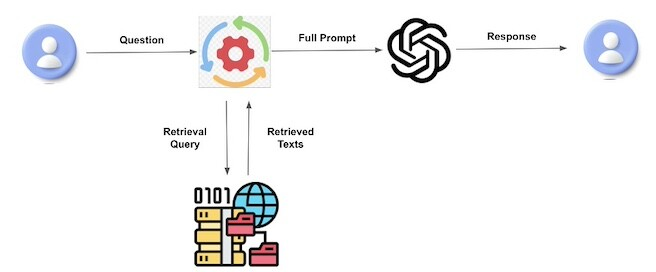

Más detalles de Langchain para RAG sobre documentos [aqui](https://python.langchain.com/v0.1/docs/modules/memory/agent_with_memory/).  
En nuestro caso, vamos a tomar un archivo de texto como fuente de informacion, y vamos a aplicarle embeddings.

In [14]:
!wget "https://raw.githubusercontent.com/V-Sher/LangChain_ReAct_Demo/refs/heads/main/data/globalcorp_hr_policy.txt"

--2024-10-31 23:33:07--  https://raw.githubusercontent.com/V-Sher/LangChain_ReAct_Demo/refs/heads/main/data/globalcorp_hr_policy.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14982 (15K) [text/plain]
Saving to: ‘globalcorp_hr_policy.txt’

globalcorp_hr_polic 100%[===================>]  14.63K  --.-KB/s    in 0s      

2024-10-31 23:33:07 (34.4 MB/s) - ‘globalcorp_hr_policy.txt’ saved [14982/14982]



In [19]:
# Get the embeddings from OpenAI
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", api_key=userdata.get('OPENAI_API_KEY'))

# Test embeddings
text = "This is a test document."
query_result = embeddings.embed_query(text)
print(len(query_result))
query_result[:5]

1536


[-0.0023576754610985518,
 0.05319516360759735,
 0.033461473882198334,
 -0.038123197853565216,
 -0.012876947410404682]

In [20]:
# Get the text as a set of documents
loader = TextLoader("/content/globalcorp_hr_policy.txt")
documents = loader.load()
print(len(documents), "documents")

1 documents


In [21]:
display_markdown(documents[0].page_content, raw=True) # Print the text (document)

**GlobalCorp Human Resources Policy**

Welcome to GlobalCorp, where our Human Resources Policy is designed to provide a comprehensive framework for employees across our offices in the United States, Germany, and Japan. We operate under an at-will employment relationship, and any contractual agreements should be documented in writing.

At the core of our culture is a commitment to professionalism and ethical conduct. Clear and respectful communication is highly valued, and a business casual dress code is encouraged.

**Work Hours:**
Employees in the United States adhere to a standard 40-hour workweek (Monday to Friday, 9 AM to 5 PM). In Germany, the standard workweek is 38 hours (Monday to Friday, 8 AM to 5 PM), and in Japan, employees work 40 hours per week (Monday to Friday, 9 AM to 6 PM). Punctuality is paramount, and employees are expected to arrive on time. Time-off requests follow country-specific guidelines.

**Compensation and Benefits - United States:**
In the United States, employees enjoy health insurance, dental coverage, and a 401(k) retirement plan. An annual budget of $1 million is allocated for employee benefits.

**Compensation and Benefits - Germany:**
In Germany, benefits include health insurance, a pension plan, and an additional 5 days of vacation annually. An annual budget of €500,000 is allocated for employee benefits.

**Compensation and Benefits - Japan:**
In Japan, employees receive health insurance, a commuting allowance, and wellness benefits. An annual budget of ¥50 million is allocated for employee benefits.

**Leave Policies - United States:**
In the United States, employees have 15 days of paid vacation and 10 days of paid sick leave annually. An annual budget of $500,000 is allocated for leave-related expenses.

**Leave Policies - Germany:**
In Germany, generous leave policies offer 30 days of paid vacation and 20 days of paid sick leave annually. An annual budget of €1 million is allocated for leave-related expenses.

**Leave Policies - Japan:**
In Japan, employees enjoy 20 days of paid vacation and 15 days of paid sick leave per year. An annual budget of ¥100 million is allocated for leave-related expenses.

**Performance Management:**
Performance reviews are conducted annually, with regular feedback provided to support professional development. GlobalCorp encourages continuous learning and allocates an annual budget of $5,000 per employee for training and development opportunities.

**Grievance and Disciplinary Procedures:**
Our grievance and disciplinary procedures are outlined on the company intranet. Termination conditions may include gross misconduct or repeated policy violations. In such cases, a disciplinary process will be followed, including a three-strike system, before termination. Employees leaving GlobalCorp should follow the exit process detailed in the employee handbook.

**Confidentiality and Data Security:**
Employees are expected to maintain confidentiality, and strict data security measures are in place. An annual budget of $1 million is allocated for cybersecurity training and awareness programs in the U.S., while budgets for Germany and Japan are €500,000 and ¥50 million, respectively.

**Health and Safety:**
Workplace safety is a shared responsibility. Emergency procedures are clearly posted throughout our office buildings, and an annual budget of $10,000, €5,000, and ¥1 million is allocated for safety drills and equipment maintenance in the U.S., Germany, and Japan, respectively.

**Communication:**
Important updates are conveyed through company-wide emails and team meetings. An annual budget of $500,000, €250,000, and ¥25 million is allocated for communication initiatives, including employee engagement events in the U.S., Germany, and Japan, respectively.

This policy undergoes an annual review to ensure relevance and compliance. Welcome to GlobalCorp, where our commitment to a diverse, inclusive, and respectful workplace is the foundation of our success.

1.	Recruitment and Selection
1.	Introduction

1.1	Effective recruitment and selection is central and crucial to the successful functioning of <Company>. It depends on finding people with the necessary skills, expertise and qualifications to deliver the Company’s strategic objectives and the ability to make a positive contribution to the values and aims of the organisation.
2.	Advertisements

2.1	Vacancies will generally be advertised in an appropriate newspaper or journal, and will not be confined to those media which, because of their particular source of applicants, provide only or mainly applicants of a particular group.

2.2	Advertisements will also be notified to the local job centre.

2.3	All vacancies will also be posted on the Company Intranet, and internal notice boards. <Company> is keen to facilitate internal promotions wherever possible as development opportunities for it’s staff.

2.4	<Company> may, on occasions, decide to restrict advertisement to internal candidates only. Furthermore junior posts will always be advertised internally in the first instance, to provide continuous development of existing members of staff unless the Management team agrees that this is not appropriate due to the specialist skills required for the post involved. 

2.5	Vacancies, which are restricted to internal candidates only will be clearly indicated on the advertisement. All internal candidates will be selected for interview on the same criteria as external candidates. 

2.6	Employees on maternity leave will receive all advertisements for posts advertised in the Company during their period of maternity leave.
3.	Application Form

3.1	Candidates for all posts will, except on some occasions when a vacancy is restricted to internal recruitment, be asked to complete a standard application form, in order that they can be judged on the basis of comparable information.

3.2		In applying for posts, all candidates will be provided with a job description, details of the appropriate conditions of service and details about the Company. A brief statement about the appointment procedure will also be provided and, if possible, an indication of the date (or week) when interviews will be held. The job description will include a list of the main duties and responsibilities of the post, together with an outline of the qualifications and experience which candidates are expected to possess.

3.3		In drawing up the job description and conditions of service the Company will ensure that no job applicant receives less favorable treatment than another on the grounds of disability, gender, race, religion or belief, age, sexual orientation, marital status, parental status, caring responsibilities or hours of work, and that no applicant is placed at a disadvantage unjustifiably by requirements or conditions which have a disproportionately adverse effect on a particular group.

3.4	Applicants will be asked to specify whether they have any disabilities, as defined in the Disability Discrimination Act 1995, and whether there are any reasonable adjustments needed for them to attend an interview. All applicants with a disability who meet the essential criteria for a job will be interviewed, and considered on their merits

3.5	Applicants will be required to supply the names and addresses of two people from whom references can be obtained, one of which should normally be the applicant's current or most recent employer. 

3.6	Only references for short listed candidates for interview will be obtained. References will normally be sought prior to interview, unless the candidate indicates otherwise.

3.7	References should normally be made in writing or email, but those received by telephone will be accepted, provided that a note of the conversation is recorded and placed on file.

3.8	All candidates will be asked to declare on the application form whether they have ever been convicted of any criminal offence which cannot be regarded as  ‘spent’ in terms of the Rehabilitation of Offenders Act 1974. 

3.9	<Optional paragraph) For posts that involve working with children and vulnerable adults / law enforcement / legal profession / finance work / licensing work (e.g. security), applicants will be asked to reveal details of ‘spent’ and ‘unspent’ convictions. Successful candidates for such posts will be required to provide the necessary documentation in order to complete a standard criminal records disclosure. Posts, which require such a disclosure, will be clearly indicated on the conditions of service and appointment procedure.

3.10	Applicants will also be required to declare if they are related to any member of staff within the Company. Canvassing of members of the Company is not permitted. No manager should be put into a position where he or she is asked to interview a person to whom they are related.

3.11 	It is the Company’s policy not to communicate further with applicants other than those who are shortlisted. A note to this effect is included in the details sent out to applicants.

3.12 	Applicants details will be recorded at the point of receipt.  All information relating to the data collected in the equality and diversity recruitment monitoring form will be hidden from all those involved in the recruitment and selection process. The information collected will be solely used for the purposes of equality monitoring.

3.13 	All completed applications forms are private and confidential and should only be made available to those directly involved in the recruitment and selection process.

3.14 	All application forms will be collated by Human Resources Department / Company Administrator and supplied to the appointing manager and interview panel for shortlisting purposes.

3.15 	A shortlist of candidates will be drawn up for interview, based entirely on merit and suitability for the post but taking account of the Company’s responsibilities in relation to the Disability Discrimination and Equalities Acts. Other than in exceptional circumstances, reasonable notice will be given to ensure that candidates have sufficient time in order to prepare for and make the necessary arrangements to attend the interview. 
4.	Selection Methods

4.1			Interviews will be held by a panel comprising of ideally three persons, but a minimum of two persons, gender balanced wherever possible. The interviewers will encourage candidates to be at ease during the interview, in order that they can give a fair and accurate impression of themselves.

4.2	<Optional paragraph>A representative from Human Resources will be present on all interviews for posts below Director level. The Company’s HR Adviser will be present on interview panels for posts of Director and above.

4.3	The selection and appointment of the Chief Executive will be made by members of the Board and the panel will be chaired by the Board Chairman.

4.4	 A set of questions will be agreed by the interview panel in advance and will be developed from the current job description for the post. The panel will seek to develop questions which ask the candidates to give examples of their previous relevant experience

4.5	All candidates will be asked the same questions in the same order, and their responses rated between 1-10. The panel will each have a copy of the questions and will score independently of each other during the interview. Time is allocated between interviews for the panel to discuss each candidate and to award a total points score. Additional notes may be made by the panel during the interview, however it should be noted that candidates will have access to all information should they request it. 

4.6			It should be remembered that an interview is a two way process, and candidates will be given every opportunity to view the offices where they will work and ask questions about the Company, to ensure that they have a full understanding of the post for which they are applying and the way the Company operates.

4.7			In addition to interviews, a range of other selection techniques may be used. In such circumstances reasonable notice and relevant information will be given to ensure that candidates have sufficient time and information to prepare.

4.8 	Candidates attending an interview will be reimbursed any reasonable expenses incurred.

4.9 			For travelling expenses this would normally be at the appropriate second-class rail fare. 

4.10 	A candidate who withdraws or refuses an offer of appointment for reasons considered by the Company to be inadequate will not be reimbursed his/her expenses.

4.11 	All appointments will be made strictly on merit and related to the requirements of the job.

4.12	The Chief Executive has delegated powers to make appointments to posts below Director level or equivalent. For Director level posts the Chief Executive will consult with the Chairman to determine Board Members’ level of involvement.

4.13 	All interviewed candidates will be notified of the outcome of the selection process as soon as possible, either by telephone or letter. 

4.14 	All unsuccessful candidates’ application forms and interview notes will be retained for one year from the date of interviews taking place. After this date they will be destroyed.
5.	Relevant Checks

5.1		All offers of employment will be made conditional upon satisfactory results from the following:

•	two satisfactory references;
•	confirmation of the right to work in this country (if appropriate)
•	Criminal Records Disclosure (if appropriate).
6.	Probationary Period
	
6.1	All appointments into the Company will be made subject to a probationary period of six calendar months. After three months a review meeting will take place between the post holder and their line manager to discuss progress. At the end of the probationary period, and subject to a satisfactory report by the appropriate head of section or line manager, employees will be notified in writing that they have successfully completed their probationary period. The probationary period can be extended by a further 3 months should the individuals line manager consider this appropriate.
7.	Recruitment Monitoring 

7.1	The Company seeks to recruit employees on the basis of their ability and the requirements of the post. 
	
7.2	The Company wants to ensure that no applicant receives less favorable treatment than another on the grounds of disability, gender, race, religion or belief, age, sexual orientation, marital status, parental status, caring responsibilities or hours of work. 
	
7.3	In order to meet this commitment, all candidates are asked to complete a recruitment monitoring form enclosed with the application form. All completed monitoring forms will be treated as confidential. The form will be separated from the application form on receipt and those involved in the selection process will not have access to it. The information given by candidates will be solely used for the purpose of monitoring the recruitment process. 


In [22]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splits = text_splitter.split_documents(documents)
print(len(splits), "splits")

# For simplicity, let's use a Chroma database in memory
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

45 splits


In [23]:
# We create a retriever for the database
top_k = 3
retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

# Test the retriever
question3 = "What are the communication initiatives?"
# question3 = "What is the allocated budget for communication initiatives?"

docs = retriever.invoke(question3)
for idx, doc in enumerate(docs):
    print(f"Document {idx + 1} ----------")
    print(doc.page_content)
print()

Document 1 ----------
**Communication:**
Important updates are conveyed through company-wide emails and team meetings. An annual budget of $500,000, €250,000, and ¥25 million is allocated for communication initiatives, including employee engagement events in the U.S., Germany, and Japan, respectively.

This policy undergoes an annual review to ensure relevance and compliance. Welcome to GlobalCorp, where our commitment to a diverse, inclusive, and respectful workplace is the foundation of our success.
Document 2 ----------
2.3	All vacancies will also be posted on the Company Intranet, and internal notice boards. <Company> is keen to facilitate internal promotions wherever possible as development opportunities for it’s staff.
Document 3 ----------
1.	Recruitment and Selection
1.	Introduction

1.1	Effective recruitment and selection is central and crucial to the successful functioning of <Company>. It depends on finding people with the necessary skills, expertise and qualifications to de

In [24]:
# Example of RAG chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
)

In [25]:
qa_chain.invoke(question3)

{'query': 'What are the communication initiatives?',
 'result': 'The communication initiatives include important updates conveyed through company-wide emails and team meetings. There is also an annual budget allocated for employee engagement events in the U.S., Germany, and Japan.',
 'source_documents': [Document(metadata={'source': '/content/globalcorp_hr_policy.txt'}, page_content='**Communication:**\nImportant updates are conveyed through company-wide emails and team meetings. An annual budget of $500,000, €250,000, and ¥25 million is allocated for communication initiatives, including employee engagement events in the U.S., Germany, and Japan, respectively.\n\nThis policy undergoes an annual review to ensure relevance and compliance. Welcome to GlobalCorp, where our commitment to a diverse, inclusive, and respectful workplace is the foundation of our success.'),
  Document(metadata={'source': '/content/globalcorp_hr_policy.txt'}, page_content='2.3\tAll vacancies will also be posted 

## **Configuración de RAG como tool**

Y ahora lo podemos agregar como tool para el agente ReAct.

In [26]:
# convert retriever into a tool
retriever_tool = create_retriever_tool(
    retriever,
    "search_hr_policy",
    "Searches and returns excerpts from the HR policy.",
)

In [27]:
# under the hood it will call the get_relevant_documents() function and return the list of chunks
retriever_tool.func

functools.partial(<function _get_relevant_documents at 0x78a4d2b75510>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x78a4d2095990>, search_kwargs={'k': 3}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n')

In [28]:
# useful to check the schema to verify the expected parameters for the function
retriever_tool.args_schema.schema()

{'description': 'Input to the retriever.',
 'properties': {'query': {'description': 'query to look up in retriever',
   'title': 'Query',
   'type': 'string'}},
 'required': ['query'],
 'title': 'RetrieverInput',
 'type': 'object'}

In [29]:
react_agent_executor = get_react_agent(llm, tools=[retriever_tool], prompt=prompt_react)

In [30]:
react_agent_executor.invoke({"input": question3})



> Entering new AgentExecutor chain...
I need to find information regarding communication initiatives from the HR policy. 
Action: search_hr_policy 
Action Input: "communication initiatives" **Communication:**
Important updates are conveyed through company-wide emails and team meetings. An annual budget of $500,000, €250,000, and ¥25 million is allocated for communication initiatives, including employee engagement events in the U.S., Germany, and Japan, respectively.

This policy undergoes an annual review to ensure relevance and compliance. Welcome to GlobalCorp, where our commitment to a diverse, inclusive, and respectful workplace is the foundation of our success.

2.3	All vacancies will also be posted on the Company Intranet, and internal notice boards. <Company> is keen to facilitate internal promotions wherever possible as development opportunities for it’s staff.

1.	Recruitment and Selection
1.	Introduction

1.1	Effective recruitment and selection is central and crucial to the

{'input': 'What are the communication initiatives?',
 'output': 'The communication initiatives include conveying important updates through company-wide emails and team meetings, with an annual budget allocated for these initiatives amounting to $500,000 for the U.S., €250,000 for Germany, and ¥25 million for Japan. These initiatives also include employee engagement events in these respective regions. The policy is reviewed annually to ensure its relevance and compliance.'}

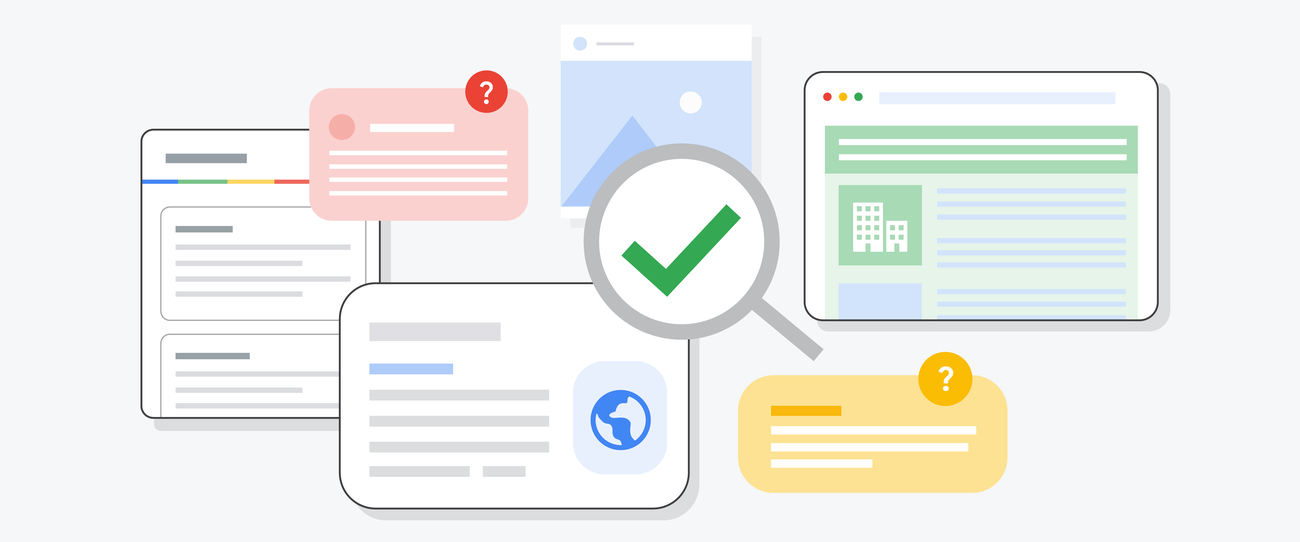

In [31]:
question4 = "What is the percentage difference in the annual budget for Japan and United States?"
# question4 = "Which of the two countries has the highest budget - Japan or Unites States?"

In [32]:
react_agent_executor.invoke({"input": question4})



> Entering new AgentExecutor chain...
To answer the question regarding the percentage difference in the annual budget for Japan and the United States, I need to find the most recent budget figures for both countries. This will involve searching for budget data or statistics that compare the two countries. 

Action: search_hr_policy(query='annual budget comparison Japan United States')  
Action Input: 'annual budget comparison Japan United States'  search_hr_policy(query='annual budget comparison Japan United States') is not a valid tool, try one of [search_hr_policy].I cannot access the budget data directly, but I can guide you on how to find that information. You would typically look for the latest budget reports or financial statistics from reliable sources such as government websites, financial news outlets, or international financial organizations. 

If you have access to specific data or reports for Japan and the United States, you could calculate the percentage difference using

{'input': 'What is the percentage difference in the annual budget for Japan and United States?',
 'output': 'Agent stopped due to iteration limit or time limit.'}

In [33]:
# cleanup Chroma
# vectorstore.delete_collection()

# **Discusion**

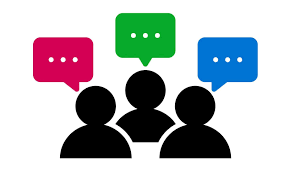

---
## **Extra: ¿Que pasaria si se combina la herramienta de búsqueda (Tavily u otra) & RAG?**

In [34]:
# TODO: Implement your tools and create your agent here


In [35]:
# react_agent_executor.invoke({"input": question4})

---